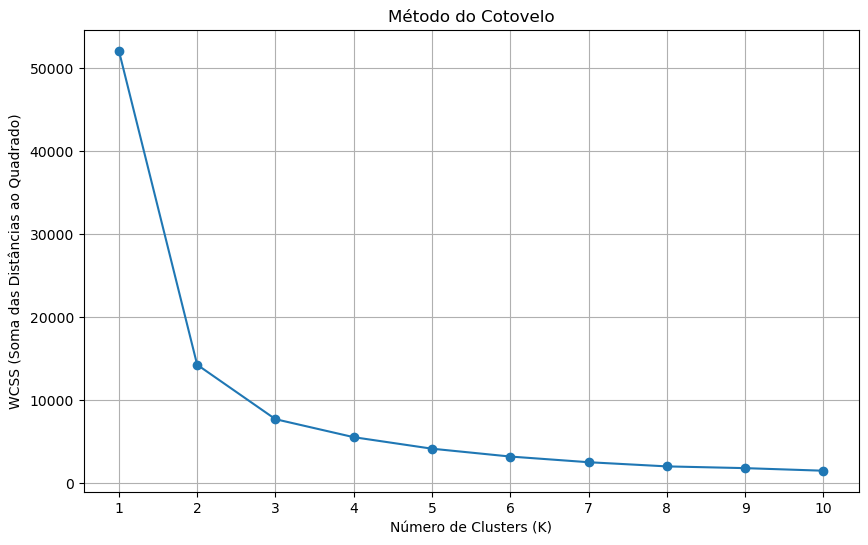

In [25]:
import matplotlib.pyplot as plt

# **Método do Cotovelo para determinar o número ideal de clusters**
wcss = []  # Lista para armazenar o WCSS para cada valor de K
K_range = range(1, 11)  # Testar valores de K de 1 a 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)  # Adiciona o WCSS (inércia) à lista

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS (Soma das Distâncias ao Quadrado)')
plt.xticks(K_range)
plt.grid()
plt.show()

In [10]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Carregar as bases (substitua pelos caminhos corretos se necessário)
db_alugueis = pd.read_csv('historico_alugueis.csv', encoding='utf-8')
db_vendas = pd.read_csv('historico_vendas.csv', encoding='utf-8')

# Padronizar os nomes das colunas para facilitar a junção
db_alugueis.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
db_vendas.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)

# Unir ambas as tabelas pela coluna 'id_do_cliente' (apenas clientes presentes em ambas)
merged_data = pd.merge(db_alugueis, db_vendas, on='id_do_cliente', how='inner')

# Selecionar e padronizar as colunas importantes para a análise
merged_filtered = merged_data[
    [
        'id_do_cliente', 'histórico_de_aluguel_(se_aplicável)',
        'valor_do_contrato_do_aluguel', 'tempo_de_aluguel'
    ]
]

# **Tratamento e padronização das colunas**

# # Padronizar 'tipo_do_cliente' usando .loc para evitar warnings
# merged_filtered.loc[:, 'tipo_do_cliente'] = (
#     merged_filtered['tipo_do_cliente'].str.strip().str.lower()
# )
# merged_filtered = merged_filtered[merged_filtered['tipo_do_cliente'].isin(['b2b', 'b2c'])]

# Tratar 'histórico_de_aluguel_(se_aplicável)' e converter 'sim/não' para 1/0
merged_filtered.loc[:, 'histórico_de_aluguel_(se_aplicável)'] = (
    merged_filtered['histórico_de_aluguel_(se_aplicável)']
    .str.strip().str.lower()
    .replace({'n': 0, 'não': 0, 'nao': 0, 'nÃo': 0, 'sim': 1})
    .fillna(0).astype(int)
)

# **Converter histórico de contratos anteriores para numérico**, tratando strings inválidas
# merged_filtered.loc[:, 'histórico_de_contratos_anteriores'] = pd.to_numeric(
#     merged_filtered['histórico_de_contratos_anteriores'], errors='coerce'
# ).fillna(0).astype(int)

# Remover símbolos de moeda e converter 'valor_do_contrato_do_aluguel' para float
merged_filtered.loc[:, 'valor_do_contrato_do_aluguel'] = (
    merged_filtered['valor_do_contrato_do_aluguel']
    .replace({'R\$': '', ',': ''}, regex=True).astype(float)
)

# Preencher valores nulos em 'tempo_de_aluguel' com 0
merged_filtered.loc[:, 'tempo_de_aluguel'] = merged_filtered['tempo_de_aluguel'].fillna(0)

# **Escalar as colunas numéricas para a clusterização**
scaler = StandardScaler()
numeric_features = merged_filtered[
    ['valor_do_contrato_do_aluguel', 'tempo_de_aluguel']
]
scaled_features = scaler.fit_transform(numeric_features)

# Adicionar colunas normalizadas ao DataFrame
merged_filtered[['valor_do_contrato_do_aluguel_scaled',
                 'tempo_de_aluguel_scaled',
                 ]] = scaled_features

# **Realizar a clusterização com K-means**
kmeans = KMeans(n_clusters=3, random_state=42)
merged_filtered['cluster'] = kmeans.fit_predict(scaled_features)

# **Análise dos Clusters**
cluster_summary = merged_filtered.groupby('cluster').agg(
    valor_médio_aluguel=('valor_do_contrato_do_aluguel', 'mean'),
    tempo_médio_aluguel=('tempo_de_aluguel', 'mean'),
    histórico_médio_contratos=('histórico_de_contratos_anteriores', 'mean'),
    tipo_cliente_mais_comum=('tipo_do_cliente', lambda x: x.mode()[0]),
    quantidade=('id_do_cliente', 'count')
).reset_index()

# Identificar o cluster mais valioso
cluster_valioso = cluster_summary.sort_values(
    ['valor_médio_aluguel', 'tempo_médio_aluguel'], ascending=False
).iloc[0]

# Filtrar clientes pertencentes ao cluster mais valioso
clientes_valiosos = merged_filtered[merged_filtered['cluster'] == cluster_valioso['cluster']]

# **Exibir resultados**
print("Resumo dos Clusters:")
print(cluster_summary)
print("\nCluster mais valioso:")
print(cluster_valioso)

print("\nClientes mais valiosos (do cluster mais valioso):")
print(clientes_valiosos[
    ['id_do_cliente', 'valor_do_contrato_do_aluguel',
     'tempo_de_aluguel']
])


C:\Users\sousa\AppData\Local\Temp\ipykernel_28340\3215156037.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'n': 0, 'não': 0, 'nao': 0, 'nÃo': 0, 'sim': 1})
C:\Users\sousa\AppData\Local\Temp\ipykernel_28340\3215156037.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_filtered[['valor_do_contrato_do_aluguel_scaled',
C:\Users\sousa\AppData\Local\Temp\ipykernel_28340\3215156037.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [4]:
display(merged_data.head())

,id_do_cliente,tipo_do_cliente,tipo_de_carro_alugado,tempo_de_aluguel,data_de_início_do_aluguel,data_final_do_aluguel,valor_do_contrato_do_aluguel,estado_de_pagamento,método_de_pagamento,quilometragem_do_carro,...,tipo_de_transmissão_y,preço_de_venda_(r$),forma_de_pagamento,status_do_pagamento,histórico_de_aluguel_(se_aplicável),id_do_contrato_de_aluguel_anterior_(se_aplicável),desconto_para_ex-cliente_de_aluguel_(%),cancelamento_da_venda,motivo_do_cancelamento_(se_aplicável),coerente
0,51556.0,b2C,sEdAn,3.0,24/03/2023,22 de june de 2023,11574,PENdENTe,boleTO,119487.0,...,auTOMÁTIcA,85083.67,fiNancIAmenTO,eM AnDAmenTO,NÃO,NaN,0.0,NÃO,NaN,True
1,51774.0,b2c,CAMINhOnETE,1.0,19/02/2022,21 de march de 2022,R$ 7558,quitADo,tRAnSfErêNcIA,27877.0,...,AUTOmática,76788.01,FiNAnCiaMEnto,EM andAMeNto,nÃO,NaN,0.0,nÃO,NaN,True
2,34161.0,B2c,suV,1.0,04/07/2023,3 de august de 2023,5248,QuiTAdO,CaRtÃo DE cRÉDITo,22129.0,...,MaNuaL,76788.01,FINaNciaMENtO,EM AnDaMenTo,NÃo,NaN,0.0,NãO,NaN,True
3,59168.0,b2c,SEdaN,1.0,26/02/2024,27 de march de 2024,R$ 4325,QUitADo,caRTãO DE cRÉDIto,148975.0,...,aUToMátICa,80829.49,tranSFeRêNCia BANCÁrIA,CompLeto,Sim,5213.0,10.0,SIm,pRObLema Na DOCuMenTaÇÃo,True
4,50756.0,B2C,sUV,3.0,12 de may de 2024,10/08/2024,R$ 26514,quitado,BOLeto,29776.0,...,AUTOMátIcA,62544.32,trANsFerÊnCiA bANCÁRiA,COmplEtO,N,NaN,0.0,siM,PRObLemA NA DOCUmentaÇãO,True


In [10]:
display(merged_filtered.head())

,id_do_cliente,tipo_do_cliente,histórico_de_aluguel_(se_aplicável),histórico_de_contratos_anteriores,valor_do_contrato_do_aluguel,tempo_de_aluguel,valor_do_contrato_do_aluguel_scaled,tempo_de_aluguel_scaled,histórico_de_contratos_anteriores_scaled,cluster
0,51556.0,b2c,0,0,11574.0,3.0,-0.597704,-0.532392,0.0,0
1,51774.0,b2c,0,0,7558.0,1.0,-0.682957,-0.819220,0.0,0
2,34161.0,b2c,0,0,5248.0,1.0,-0.731995,-0.819220,0.0,0
3,59168.0,b2c,1,0,4325.0,1.0,-0.751588,-0.819220,0.0,0
4,50756.0,b2c,0,0,26514.0,3.0,-0.280551,-0.532392,0.0,0


In [11]:

display(merged_filtered.head(50))

,id_do_cliente,tipo_do_cliente,histórico_de_aluguel_(se_aplicável),histórico_de_contratos_anteriores,valor_do_contrato_do_aluguel,tempo_de_aluguel,valor_do_contrato_do_aluguel_scaled,tempo_de_aluguel_scaled,histórico_de_contratos_anteriores_scaled,cluster
0,51556.0,b2c,0,0,11574.0,3.0,-0.597704,-0.532392,0.0,0
1,51774.0,b2c,0,0,7558.0,1.0,-0.682957,-0.819220,0.0,0
2,34161.0,b2c,0,0,5248.0,1.0,-0.731995,-0.819220,0.0,0
3,59168.0,b2c,1,0,4325.0,1.0,-0.751588,-0.819220,0.0,0
4,50756.0,b2c,0,0,26514.0,3.0,-0.280551,-0.532392,0.0,0
5,47845.0,b2c,0,0,6195.0,3.0,-0.711891,-0.532392,0.0,0
6,80458.0,b2c,0,0,2991.0,1.0,-0.779907,-0.819220,0.0,0
7,2716.0,b2c,1,0,3501.0,1.0,-0.769081,-0.819220,0.0,0
8,43669.0,b2c,0,0,36084.0,6.0,-0.077395,-0.102149,0.0,0
9,43669.0,b2c,0,0,36084.0,6.0,-0.077395,-0.102149,0.0,0


In [51]:
print(clientes_valiosos['id_do_cliente'].head(10))

77     67630.0
104    67364.0
111    68201.0
116    55179.0
117    33573.0
130    68501.0
138    35753.0
147    70128.0
177    74645.0
178    74645.0
Name: id_do_cliente, dtype: float64


In [8]:
X, y = make_blobs(random_state=42)
silhouette_score(X, kmeans.fit_predict(X))

np.float64(0.8469881221532085)

KeyError: "['tipo_do_cliente'] not in index"